In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [6]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    #changed
    
    each = 0
    for i in probs:
        # if probability equals to 0
        #entropy is o, as 0 * log(0) = 0
        if i==0:
            each+=0
        else:
            each+=-i*np.log2(i)
    
    return each

    #orignial
    #-probs.dot(np.log2(probs)).apply(log(x) if x !=0 else -inf)


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 



In [7]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [8]:
food

,Food ID,Survey ID,Food Name,Survey flag,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)",...,Total saturated fat (g),Total monounsaturated fat (g),Total polyunsaturated fat (g),Linoleic acid (g),Alpha-linolenic acid (g),C20:5w3 Eicosapentaenoic (mg),C22:5w3 Docosapentaenoic (mg),C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),Total trans fatty acids (mg)
0,10F40019,31103001,"Beef, extract, bonox",NaN,401,401,56.6,16.6,0.2,6.5,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00
1,13A12001,31302001,"Basil, dried",NaN,1079,774,10.0,18.2,5.5,15.5,...,2.36,1.40,0.61,0.26,0.34,0.00,0.00,0.0,0.000,0.00
2,10E10113,31302002,"Cardamom, seeds, ground",NaN,1333,1109,8.3,10.8,6.7,40.5,...,2.20,2.81,1.39,1.00,0.39,0.00,0.00,0.0,0.000,0.00
3,10E10098,31302003,Chilli (chili) powder,NaN,1441,1167,7.8,12.3,16.8,20.5,...,2.41,3.15,7.85,7.32,0.52,0.00,0.00,0.0,0.000,0.00
4,10E10107,31302004,"Chilli (chili), dried, ground",NaN,1573,1355,6.6,14.1,16.8,29.6,...,2.42,3.16,7.89,7.36,0.52,0.00,0.00,0.0,0.000,0.00
5,10E10099,31302005,"Cinnamon, dried, ground",NaN,1026,591,9.8,4.2,2.7,25.5,...,1.35,0.96,0.22,0.17,0.04,0.00,0.00,0.0,0.000,0.00
6,10E10106,31302006,"Cloves, dried, ground",NaN,1536,1262,5.9,6.0,17.3,30.8,...,4.69,1.83,9.49,3.53,0.81,11.90,254.15,0.0,266.044,0.00
7,10E10100,31302007,"Coriander seed, dried, ground",NaN,1476,1125,6.1,13.0,19.8,10.5,...,1.11,15.79,2.04,2.04,0.00,0.00,0.00,0.0,0.000,0.00
8,10E10093,31302008,"Cumin (cummin) seed, dried, ground",NaN,1915,1831,7.3,18.4,25.8,33.3,...,1.80,18.37,4.29,4.06,0.23,0.00,0.00,0.0,0.000,0.00
9,10E10096,31302009,Curry powder,NaN,1459,1242,9.5,12.7,13.8,30.9,...,2.85,7.08,3.33,2.70,0.63,0.00,0.00,0.0,0.000,0.00


In [9]:
##Question 1

###1a
#build a new data frame called new_food which contains only the continuous features from food nutrient 2011 13 AHS.csv. 
#The features starting from "Energy, with dietary fibre (kJ)" and ranging to "Total trans fatty acids (mg)" are selected 
#ranging from index 4 to 57 in food
new_food = food.iloc[:, 4 : 57]



###1b
#standardise each feature individually
new_food_values = new_food.values 

#uses function StandardScaler()
scaler = StandardScaler()
new_food_scaled = scaler.fit_transform(new_food_values)

#create a new data frame called foodscaled which contained all the standardised features
foodscaled = pd.DataFrame(data=new_food_scaled,columns=new_food.columns)



###1c
print("***\nQ1.c: foodscaled matrix details")

#shape return two values: numbers of food and number of attributes in this case
#shape has the value of rows and columns, indexing them to get them seperately
num_rows = foodscaled.shape[0]
num_columns = foodscaled.shape[1]
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)

#find the min value in foodscaled
#first find the minimum value of each column and then find the minimum value of that series
min_foodscaled = round(foodscaled.min(axis = 0).min(), 1)
#find the max value in foodscaled
#first find the maximum value of each column and then find the maximum value of that series
max_foodscaled = round(foodscaled.max(axis = 0).max(), 1)
#find the mean in foodscaled
#first find the mean of each column and then find the average value of that series
mean_foodscaled = round(foodscaled.mean(axis = 0).mean(), 1)
#find the mean in foodscaled
#first find make foodscaled into a column and find the overall standard deviation
std_foodscaled = round(foodscaled.stack().std() , 1)

#print out min, max, mean, and standard deviation of foodscaled
print("Min: ", min_foodscaled)
print("Max: ", max_foodscaled)
print("Mean: ", mean_foodscaled)
print("Standard Deviation: ", std_foodscaled)
print("***")
print("\n")



***
Q1.c: foodscaled matrix details
Number of rows:  5740
Number of columns:  53
Min:  -2.0
Max:  75.8
Mean:  -0.0
Standard Deviation:  1.0
***




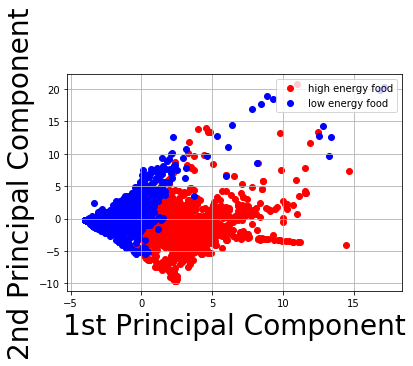

In [5]:
#Question 2


###2a

#Create an attribute EnergyLevel which has value ”1” if Energy, 
#with dietary fibre (kJ) is greater than 1000 kJ and ”0” otherwise
foodscaled['EnergyLevel'] = new_food['Energy, with dietary fibre (kJ)'].apply(lambda x: 1 if x > 1000 else 0)



###2b

#Using PCA(principal components analysis) to foodscaled.
#and obtained the computed data in foodreduced(data frame).

#create a new data frame foodreduced
foodreduced = pd.DataFrame()

#compute the two princinple components
sklearn_pca = PCA(n_components=2)   #we want just the first two PCs

#a data frame of the two principle components
foodscaled_sklearn = sklearn_pca.fit_transform(foodscaled)

#assigning the two PCs to the new data frame, foodreduced
foodreduced["1st Principle Component"] = foodscaled_sklearn[:,0]
foodreduced["2nd Principle Component"] = foodscaled_sklearn[:,1]



###2c

#Plot a scatter plot using foodreduced(data frame).
#In the scatter plot a food should have red color if it has ‘High’ energy (EnergyLevel of ”1”) 
#and blue if it has ‘Low’ energy (EnergyLevel of ”0”). 

#have a new column of Energy Level
foodreduced['EnergyLevel'] = foodscaled['EnergyLevel']

#seperate the two different energy level foods into two data frame from foodreduced
#high energy food
high_energy_food = foodreduced[(foodreduced['EnergyLevel'] == 1)]
#low energy food
low_energy_food = foodreduced[(foodreduced['EnergyLevel'] == 0)]

#plot high energy food with red color
high = plt.scatter(high_energy_food["1st Principle Component"], high_energy_food["2nd Principle Component"], color = 'red')
#plot low energy food with blue color
low = plt.scatter(low_energy_food["1st Principle Component"], low_energy_food["2nd Principle Component"], color = 'blue')

#add labels to the plot
plt.xlabel('1st Principal Component', fontsize=28)
plt.ylabel('2nd Principal Component', fontsize=28)

#have the legend of the two types of food
plt.legend((high, low), ('high energy food', 'low energy food'), loc = 'upper right')

plt.grid(True)

plt.show()


In [10]:
new_food

,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)","Available carbohydrates, without sugar alcohol (g)",Starch (g),Total sugars (g),Added sugars (g),...,Total saturated fat (g),Total monounsaturated fat (g),Total polyunsaturated fat (g),Linoleic acid (g),Alpha-linolenic acid (g),C20:5w3 Eicosapentaenoic (mg),C22:5w3 Docosapentaenoic (mg),C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),Total trans fatty acids (mg)
0,401,401,56.6,16.6,0.2,6.5,6.5,6.5,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00
1,1079,774,10.0,18.2,5.5,15.5,15.5,15.5,0.0,0.0,...,2.36,1.40,0.61,0.26,0.34,0.00,0.00,0.0,0.000,0.00
2,1333,1109,8.3,10.8,6.7,40.5,40.5,31.0,9.5,0.0,...,2.20,2.81,1.39,1.00,0.39,0.00,0.00,0.0,0.000,0.00
3,1441,1167,7.8,12.3,16.8,20.5,20.5,10.4,10.1,0.0,...,2.41,3.15,7.85,7.32,0.52,0.00,0.00,0.0,0.000,0.00
4,1573,1355,6.6,14.1,16.8,29.6,29.6,19.2,10.4,0.0,...,2.42,3.16,7.89,7.36,0.52,0.00,0.00,0.0,0.000,0.00
5,1026,591,9.8,4.2,2.7,25.5,25.5,11.7,13.8,0.0,...,1.35,0.96,0.22,0.17,0.04,0.00,0.00,0.0,0.000,0.00
6,1536,1262,5.9,6.0,17.3,30.8,30.8,28.1,2.7,0.0,...,4.69,1.83,9.49,3.53,0.81,11.90,254.15,0.0,266.044,0.00
7,1476,1125,6.1,13.0,19.8,10.5,10.5,1.7,8.8,0.0,...,1.11,15.79,2.04,2.04,0.00,0.00,0.00,0.0,0.000,0.00
8,1915,1831,7.3,18.4,25.8,33.3,33.3,31.0,2.3,0.0,...,1.80,18.37,4.29,4.06,0.23,0.00,0.00,0.0,0.000,0.00
9,1459,1242,9.5,12.7,13.8,30.9,30.9,20.7,10.2,0.0,...,2.85,7.08,3.33,2.70,0.63,0.00,0.00,0.0,0.000,0.00


Question 2d answer here
#1. What does it show? 
    The visualisation of the two clusters - high energy food(red) and low energy food(blue) using PCA.
    PCA captures the largest variability of the data in 2D.
    There are lots of noises on the graph.

#2. How can it be interpreted? 
    The food in each cluster are fairly close except some noise.
    For each of the cluster it has a positive linear relationship between the two components

#3. What are the advantages and disadvantages of using PCA for visualising this food dataset?
    Advantages: 1. PCA reduced the dimensionality, shrinks into a 2 dimension which avoiding "the curse of           dimensionality".
                2. Reduce amount of time and memory required by data processing algorithms.
                3. Allow data to be more easily visualized.
    Disadvantages: 1.However, the diadvantage would be PCA is not helpful in
                 minimizing the irrelevant features or noise.


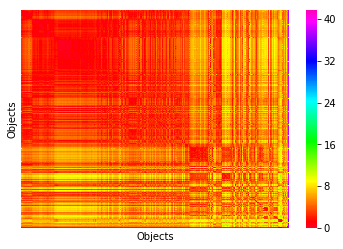

In [6]:
#Question 3


###3a
#have a new feature in foodscaled, "Food Category"
#which slice the string in food['Survey ID'] to only have the first two digits

#using astype to change the datatype of the Survey ID attribute into the string type
SurveyID = food['Survey ID'].astype(str)
#New attribute Food category using string slicing to get the first two digits
foodscaled['Food Category'] = SurveyID.str.slice(stop = 2)



###3b
#Using the new attributes created in 3(a)
# stores food with categories 13, 20 and 24 into a new data frame called foodscaledsample

#create a new data frame called foodscaledsample
foodscaledsample=pd.DataFrame()

#create a new list called categories which stored foodscaled['Food Category']
#using this list can help easy indexing
categories=[]
for attr, value in foodscaled['Food Category'].items():
    categories.append(value)

#using a while loop to find all the food that has categories of 13, 20 and 24
i = 0
while i < 5740:
    if categories[i] == '13' or categories[i] == '20' or categories[i] == '24':
        #append the rows of food that are selected to the new dataframe
        #excluding the attributes "EnergyLevel" and "Food Category" in foodscaled
        foodscaledsample = foodscaledsample.append(foodscaled.iloc[i:i+1,0:53])
        i += 1
    else:
        #if the food is not in the categrories, do nothing and i++
        i += 1

###3c
#Visualise the dissimilarity matrix for the data frame foodscaled sample 

#foodscaledsample_2=foodscaledsample.copy().values
#np.random.shuffle(foodscaledsample_2)   ####randomise the order of rows (objects)
#sq = squareform(pdist(foodscaledsample_2))   ###commpute the dissimilarity matrix


#apply VAT() function provided at the begaining of codes
#RV is the ordered dissmilarity matrix that obtained
RV, C, I = VAT(foodscaledsample)


###3d
#plot a heat map using the dissimilarity martrix calculated in 3(c) 

#select 'gist_rainbow' as the color map and plot the heat map
#using this color map can see three clusers, although the last two isn't clearly seen as the first cluster
x = sns.heatmap(RV, cmap = 'gist_rainbow', xticklabels = False, yticklabels = False)

#set x and y labels for the map
x.set(xlabel = 'Objects', ylabel = 'Objects')

plt.show()





Question 3e here
#1. How many clusters are apparent in your heatmap? 
    In my heat map, 3 clusters are apparently to be seen.



#2. Is this expected (why/why not)? 
    Yes. Three clusters are expected as foodscaledsample contained three categories which was build in 3(b).



#3. Why does use of different colormaps produce visualisations of varying usefulness? 
    Use of the right colormaps can justify people's prediction of the clustering in the case of this problem.
     There are different colormaps in matplotlib library under cmp.
     For example, 'Perceptually Uniform Sequential', 'Sequential', 'Sequential (2)', 'Diverging', 'Cyclic'
            'Qualitative', 'Miscellaneous' are 7 types of colormaps.
     These types are classified into three classes: sequential, diverging and quanlitative.  

          Sequential: slowly changes in color is used often using a single hue. 
                  It is suitable for representing ordered information
          Diverging: similar with squential, however there are commonly two colors of variation which meet in the middle.
                  It was used when the data deviates around zero
          Qualitative: uses miscellaneous colors
                  It was used for information with no ordering.



#4. Explain what properties an optimal colormap should have for this task.
     An optimal colormap can clearly show the predicted clustering of the data along the diagonal line.
     Also maximize the distinguishability of the cluster from the background, making the clusters obvious.

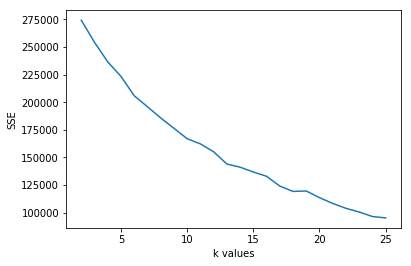

In [7]:
#Question 4

###4a 
#Draw a plot of the SSE value of the k-means clustering of the dataset (y-axis), versus k value (x axis)
#uses KMeans as the dataset


sse = {}
#using foodscaled, k in range(2,26,1)
#This requires generation of 24 different k-means clusterings
for k in range(2, 26):
    #use random state=100 and default values for all other parameters of the KMeans function
    #except n clusters, which will need to be varied
    kmeans = KMeans(n_clusters = k, random_state = 100).fit(foodscaled.iloc[:, 0:53])
    foodscaled["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center


#plot the graph, using keys as x axis and values as y axis
plt.plot(list(sse.keys()), list(sse.values()))

#Add labels to the graph
plt.xlabel("k values")
plt.ylabel("SSE")

#plot the graph
plt.show()


Question 4b answer here

The graph in 4(a) is a curve that slowing dowing decreasing speed.
The elbow point from the graph is approximating at 24, is the point of maximum curvature.
This is expected as the total number of categories are 23. 
Some of the categories may have much less food in that category that can cause bias
the elbow point is the optimal number of clusters (k) to use in k-means clustering



In [8]:
num_categories = len(foodscaled['Food Category'].value_counts())
print("The total numbers of categories are", num_categories)

The total numbers of categories are 23


In [9]:
###Question 5


###5a
#Draw a 10*10 Pearson correlation matrix for the first 10 nutrients in food(data frame).
#Each cell is the person correlation between the two attributes in the x and y column.

#select first 10 nutrients from food
nutrients_10 = food.iloc[:, 4 : 14]

#compute the Pearson correlation matrix
corr = nutrients_10.corr()

#plot the matrix
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)","Available carbohydrates, without sugar alcohol (g)",Starch (g),Total sugars (g),Added sugars (g)
"Energy, with dietary fibre (kJ)",1,1,-0.88,0.16,0.82,0.46,0.46,0.38,0.3,0.31
"Energy, without dietary fibre (kJ)",1,1,-0.87,0.17,0.82,0.45,0.45,0.36,0.3,0.31
Moisture (g),-0.88,-0.87,1,-0.16,-0.49,-0.73,-0.72,-0.6,-0.45,-0.43
Protein (g),0.16,0.17,-0.16,1,0.061,-0.25,-0.25,-0.093,-0.28,-0.23
Total fat (g),0.82,0.82,-0.49,0.061,1,-0.059,-0.057,-0.064,-0.0086,0.026
"Available carbohydrates, with sugar alcohols (g)",0.46,0.45,-0.73,-0.25,-0.059,1,1,0.76,0.68,0.63
"Available carbohydrates, without sugar alcohol (g)",0.46,0.45,-0.72,-0.25,-0.057,1,1,0.76,0.68,0.63
Starch (g),0.38,0.36,-0.6,-0.093,-0.064,0.76,0.76,1,0.073,0.065
Total sugars (g),0.3,0.3,-0.45,-0.28,-0.0086,0.68,0.68,0.073,1,0.93
Added sugars (g),0.31,0.31,-0.43,-0.23,0.026,0.63,0.63,0.065,0.93,1


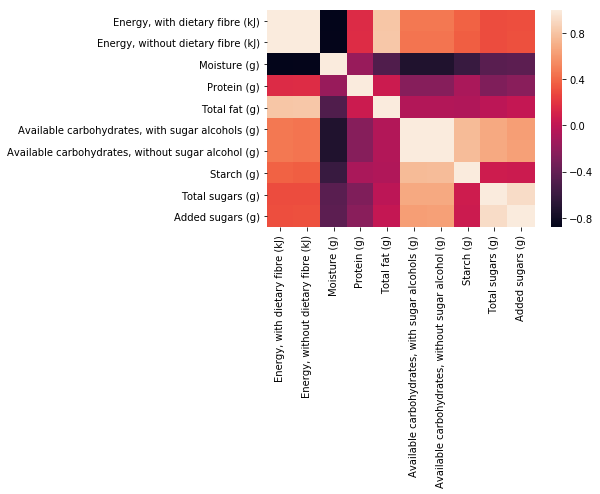

In [10]:
###5a (continue)
#Plot a heatmap for your computed correlation matrix, including feature names on each axis of the heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.show()

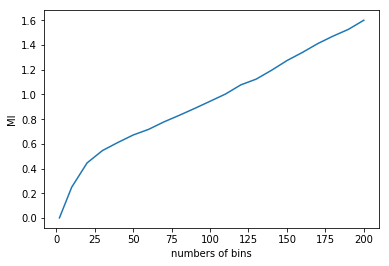

In [11]:
###5b code
#choosing nutrients ’Protein (g)’ and ’Energy, with dietary fibre (kJ)’ from food.
#using [2, 10, 20, 30, 40, ... , 200] as the numbers of bins.
#computes a series of Mutual Information (MI) values, one for each number of bins.
#plot MI as y axis and number of bins as x axis

#a function of extracting columns from data
def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame

#select the two columns 'Protein (g)', 'Energy, with dietary fibre (kJ)' using function created
selected_columns = ['Protein (g)', 'Energy, with dietary fibre (kJ)']
selected = select_columns(food, selected_columns)

#create a list of number of bins
#[2, 10, 20, 30, 40, ... , 200]
num_bins =[2]
for i in range(10,201,10):
    num_bins.append(i)

#create a data frame used for mutual_info()
#the data frame that have two columns of the preprocessing data
wanted = pd.DataFrame()

#create a list to append MI after compute
MI=[]

#use a loop to find the MI of different size of bins
j=0
while j<21:
    #binning the two selected columns separately
    Protein_bins = pd.cut(selected.iloc[:,0],num_bins[j])
    Energy_bins = pd.cut(selected.iloc[:,1],num_bins[j])
    
    #append to the new data frame
    wanted['Protein_bins'] = Protein_bins
    wanted['Energy_bins'] = Energy_bins
    
    #append the calculate MI to the list
    #the mutual_info(df) can not calculate log(0) so I make changes to entropy(probs)
    MI.append(mutual_info(wanted)['MI'])
    
    #iterate
    j+=1

    
#create a series of MI and index equals to number of bins 
s = pd.Series(MI,index=num_bins)

#plot the the series
#MI as y axis and number of bins as x axis
plt.plot(s)

#Add labels to the graph
plt.ylabel("MI")
plt.xlabel("numbers of bins")

plt.show()

Question 5b comment here

MI is the measure of correlation between the two attributes, 'Protein (g)', 'Energy, with dietary fibre (kJ)'
MI increases rapidly and then, at approximately 24 bins, it quite abruptly slows down it speed of increase
From 24 bins onward, the change of MI is pretty consistence
In conclusion, the more bins, the less surprise and more predictive to know the other feature
Since MI is the information shared betwwen two attributes

In [12]:
###5c code
#for all 53 features in food, find the top 10 pairs that have the highest Pearson correlation

#ranging from index 4 to 57 in food
new_food = food.iloc[:, 4 : 57]

#a 53*53 Pearson correlation matrix
corr_all_attr = new_food.corr()

#create a data frame that store the two attributes name and their pearson correlation
corr_2 = pd.DataFrame()

#obtain all the attributes names
food_name = new_food.iloc[0,:]
attr = food_name.index

#two lists used to store the name
attr_1 = []
attr_2 = []
#a list to store the correlation between to attributes
corr_attrs =[]

#use a loop to append the three lists created
i=0
while i<53:
    j=0
    #two attributes are not the same
    while i!=j and j<53:
        #two attributes
        attr_1.append(attr[i])
        attr_2.append(attr[j])
        #the absolute value of the correlation strength
        corr_attrs.append(abs(corr_all_attr.iloc[i,j]))
        j+=1
    i+=1

#create a data frame of two columns of attributes and correlation strength
corr_2['Attribute 1'] = attr_1
corr_2['Attribute 2'] = attr_2
corr_2['Pearson correlation'] = corr_attrs

#sort the data frame by pearson correlation
#find the top 10 highest pairs of correlation strength
corr_2.sort_values(by=['Pearson correlation'], ascending=False).head(10)



,Attribute 1,Attribute 2,Pearson correlation
464,Vitamin E (mg),Alpha-tocopherol (mg),0.999528
0,"Energy, without dietary fibre (kJ)","Energy, with dietary fibre (kJ)",0.998608
135,Provitamin A (b-carotene equivalents) (µg),Beta-carotene (µg),0.995961
20,"Available carbohydrates, without sugar alcohol...","Available carbohydrates, with sugar alcohols (g)",0.995466
54,Free sugars (g),Added sugars (g),0.988894
324,Dietary folate equivalents (µg),Total Folates (µg),0.985763
1080,Linoleic acid (g),Total polyunsaturated fat (g),0.973640
323,Dietary folate equivalents (µg),Folic acid (µg),0.958112
150,Vitamin A retinol equivalents (µg),Preformed vitamin A (retinol) (µg),0.954100
1325,Total long chain omega 3 fatty acids (mg),C22:6w3 Docosahexaenoic (mg),0.952762


In [13]:
###5c code (continue)
#plot MI(y axis) between each featrue pair and number of bins(x axis)

#build a temporary data frame that contain the temporary two preprocessing attributes
#which is used to calculate MI
temp_df = pd.DataFrame()

#create a data frame that store the two attributes name and their MI
MI_2 = pd.DataFrame()

#create list of features and corresponding MI
attr_1 = []
attr_2 = []
MI_2_attrs = []

#a loop compute MI between 2 feature
i=0
while i<53:
    j=0
    #In the temporary data frame the first feature
    #discretised data into bins
    first_attr = pd.cut(new_food.iloc[:,i],20)
    temp_df['1'] = first_attr
    while j<53 and i!=j:
        #two attributes
        attr_1.append(attr[i])
        attr_2.append(attr[j])
        #discretised data into bins
        second_attr = pd.cut(new_food.iloc[:,j],20)
        #In the temporary data frame the second feature
        temp_df['2'] = second_attr
        #calculate MI of temp_df
        MI_2_attrs.append(mutual_info(temp_df)['MI'])
        j+=1
    i+=1

#create the data frame of two columns of attributes and MI
MI_2['Attribute 1'] = attr_1
MI_2['Attribute 2'] = attr_2
MI_2['MI'] = MI_2_attrs

#sort the data frame by MI
#find the top 10 highest pairs of MI
MI_2.sort_values(by=['MI'], ascending=False).head(10)

,Attribute 1,Attribute 2,MI
0,"Energy, without dietary fibre (kJ)","Energy, with dietary fibre (kJ)",3.140250
20,"Available carbohydrates, without sugar alcohol...","Available carbohydrates, with sugar alcohols (g)",3.070813
1,Moisture (g),"Energy, with dietary fibre (kJ)",1.880160
2,Moisture (g),"Energy, without dietary fibre (kJ)",1.791029
864,Tryptophan (mg),Protein (g),1.359985
54,Free sugars (g),Added sugars (g),1.253871
27,Starch (g),"Available carbohydrates, without sugar alcohol...",1.101232
26,Starch (g),"Available carbohydrates, with sugar alcohols (g)",1.095449
53,Free sugars (g),Total sugars (g),0.978975
6,Total fat (g),"Energy, with dietary fibre (kJ)",0.959014


Question 5c comment here

similarities: 2 out of 10 pairs are same
differences: 8 out of 10 pairs are different
The Pearson correlation is a measure of the linear correlation between two random variables.
Mutual information can detect both linear and non linear dependencies
The features are different probably because of the choice of number of bins, since the feature is continous
Different bin choices will lead to different estimations of mutual information

***
Q6.a: Train Test Split Results
X_train matrix: 4592 53
y_trian labels: 4592 1
X_test matrix: 1148 53
y_test matrix: 1148 1
***


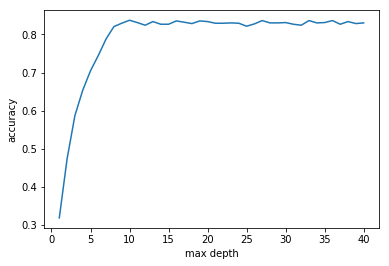

In [14]:
##Question 6
#predicting the Food category label, using the values of the various nutrients.

###6a
#Food category is the class label
classlabel = foodscaled['Food Category']


#randomly splitting the foodscaled data
#obtain two matrices: X train and X test, and two vectors/columns: y train and y test
#80% of data is training and 20% of data is testing size
X_train, X_test, y_train, y_test = train_test_split(foodscaled.iloc[:, 0 : 53], classlabel, train_size = 0.80,
                                                    test_size = 0.20)


print("***\nQ6.a: Train Test Split Results")

#print X train, X test, y train and y test number of rows and columns
print("X_train matrix:", np.shape(X_train)[0], np.shape(X_train)[1])
print("y_trian labels:", np.shape(y_train)[0], "1")
print("X_test matrix:", np.shape(X_test)[0], np.shape(X_test)[1])
print("y_test matrix:", np.shape(y_test)[0], "1")

print("***")


###6b
#Using the same training and testing data from 6(a)
#changing the max depth parameter for decision tree. range(1,41)
#draw a plot of accuracy (y-axis) against max depth (x-axis)

#create a list, convenient to append calculated accuracy
accuracy = []

#use while loop to iterate different value for max depth
i = 1
while i < 41:
    #using function to create classifier
    classifier = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    #append accuracy to list
    accuracy.append(accuracy_score(y_test, y_pred))
    i += 1

#create a series having accuracy as value and range(1,41) as index
s = pd.Series(accuracy,index = range(1,41))
plt.plot(s)

#Add labels to the graph
plt.xlabel('max depth')
plt.ylabel('accuracy')


plt.show()


Question 6c comment here

the accuracy boost from 0.32 to 0.85, 1 to 8 max depth
After approximately 8 (max depth), the accuracy relatively stable around 0.85 and fluctuate.
local peaks when max depth are 12, 18, 21, 31, 39
staring from max depth = 1, the accuracy is at its lowest
The higher value of maximum depth causes overfitting, and a lower value causes underfitting.

In [15]:
#Question 7

###7a
#using KNN and k = 1 transforming X train and y train
#predict and calculate the accuracy of the model, both the train and test set

print("***\nQ7a: Food Category prediction using K-NN (k=1)")

#set k = 1, n_neighbors = 1
#using K nearest neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, np.ravel(y_train))

#make prediction on both X_train and X_test
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

#find the accuracy of the two prediction
print("Train accuracy:", round(accuracy_score(y_train, train_pred) * 100, 1), '%')
print("Test accuracy:", round(accuracy_score(y_test, test_pred) * 100, 1), '%')

##7b
#using KNN and k = 3 transforming X train and y train
#predict and calculate the accuracy of the model, both the train and test set

print("***\nQ7a: Food Category prediction using K-NN (k=3)")

#set k = 3, n_neighbors = 3
#using K nearest neighbor
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, np.ravel(y_train))

#make prediction on both X_train and X_test
train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

#find the accuracy of the two prediction
print("Train accuracy:", round(accuracy_score(y_train, train_pred) * 100, 1), '%')
print("Test accuracy:", round(accuracy_score(y_test,test_pred) * 100, 1), '%')

***
Q7a: Food Category prediction using K-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 88.3 %
***
Q7a: Food Category prediction using K-NN (k=3)
Train accuracy: 93.5 %
Test accuracy: 86.4 %


Question 7c comment here
for parts a) and b):
    similarities: the train accuracy is higher than test accuracy
                  Since the model is built using training set.
                  When k = 1, the train accuracy is 100%.
    differences: when k = 5, the accuracy for both train and test set are lower when k = 1
                 the noise is smaller, however, the boundry betwwen each class become more and more blur,
                 which cause the low accuracy when k increases



Question 7d comment here
the reported accuracy may be over-optimistic:

    #uses function StandardScaler()
    scaler = StandardScaler()
    new_food_scaled = scaler.fit_transform(new_food_values)
    #create a new data frame called foodscaled which contained all the standardised features
    foodscaled = pd.DataFrame(data=new_food_scaled,columns=new_food.columns)
    
Because in quuestion 1, standardisation was applied to datascaled, not the split X_train data.
The test data is also standardised which cause data leakage.
This problem can be solved by first split the data to training set and testing set, 
and then do the standardisation only on the train data, X_train


In [16]:
#Question 8 code
#Feature generation Method 1: Interactive term pairs


#create a dataframe with all the original features
data = foodscaled.iloc[:, 0 : 53]


#create new features fpair = f1 × f2, 
#the combination of 53 attributes by selecting two attributes without repeat
i = 0
while i < 53:
    j = 0
    while j < 53 and i != j:
        data[str(i + 1) + '_' + str(j + 1)] = data.iloc[:, i] * data.iloc[:, j]
        j += 1 
    i += 1


#defined the classlabel as "Food Category"
classlabel = foodscaled['Food Category']

#split the data in to training instances and testing instances
X_train, X_test, y_train, y_test = train_test_split(data, classlabel, train_size = 0.80, test_size = 0.20)
    
def MI(data):
    #the number of features N
    num_features = np.shape(data)[1]
    
    #create a list of all the orignal and generated features
    g = data.iloc[0, :]
    att = g.index

    #create a dataframe to computes 
    #the MI between wach feature and the class label ("Food Category")
    MI_train = pd.DataFrame()


    #the data frame used for the function mutual_info()
    #It should has a list of class label ("Food Category") and 
    #a list of feature
    temp = pd.DataFrame(data = y_train, columns = ['Food Category'])

    #create a list of attributes
    attri = []

    #create a list of MI of each feature and the class label
    MI_new = []

    #using a while loop to compute MI between the class label and each feature
    #only doing this on the training data
    i=0
    while i<num_features:
        a = data.iloc[:, i]
        temp['Attributes'] = a
        attri.append(att[i])
        MI_new.append(mutual_info(temp)['MI'])
        i += 1
    
    
    
    #obtain a data frame MI_train with each feature and its correponding MI with class label
    MI_train['Attributes'] = attri
    MI_train['MI'] = MI_new
    return MI_train


In [17]:
#choosing different n features
#trails with n = 50, 500, 1000
#N = 1431, n < N


MI_train_all_features = MI(data)

#sort the features from the highest to lowest and selected the top n=50 features
selected_50 = MI_train_all_features.sort_values(by=['MI'], ascending=False).head(50)
#sort the features from the highest to lowest and selected the top n=500 features
selected_500 = MI_train_all_features.sort_values(by=['MI'], ascending=False).head(500)
#sort the features from the highest to lowest and selected the top n=1250 features
selected_1250 = MI_train_all_features.sort_values(by=['MI'], ascending=False).head(1250)


def accuracy(k, df):
    #creating new features for both the training data and the testing data
    X_train_new = pd.DataFrame()
    X_test_new = pd.DataFrame()
    
    #have a list of all the selected features
    attr_name = df['Attributes']
    
    #generated features for X_train_new with the top n MI features
    for name in attr_name:
        X_train_new[str(name)] = X_train[str(name)]
        X_test_new[str(name)] = X_test[str(name)]
    
    #using k nearest neighbor
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_new, np.ravel(y_train))
    test_pred=knn.predict(X_test_new)
    test_accuracy = round(accuracy_score(y_test,test_pred) * 100,1)
    return test_accuracy


print("Test accuracy of 50 features selected:", accuracy(1, selected_50),'%')
print("Test accuracy of 500 features selected:", accuracy(1, selected_500),'%')
print("Test accuracy of 1000 features selected:", accuracy(1, selected_1250),'%')

Test accuracy of 50 features selected: 83.3 %
Test accuracy of 500 features selected: 89.0 %
Test accuracy of 1000 features selected: 89.1 %


In [18]:
#change the numbers of generated features
#randomly selecting 50, 200, 1000 features

data_50 = data.sample(50, axis=1)
data_200 = data.sample(200, axis=1)
data_1000 = data.sample(1000, axis=1)

MI_train_50_features = MI(data_50)
MI_train_200_features = MI(data_200)
MI_train_1000_features = MI(data_1000)

#sort the features from the highest to lowest and choose randomly 50 attributes
attributes_50 = MI_train_50_features.sort_values(by=['MI'], ascending=False)
#sort the features from the highest to lowest and choose randomly 200 attributes
attributes_200 = MI_train_200_features.sort_values(by=['MI'], ascending=False)
#sort the features from the highest to lowest and choose randomly 1000 attributes
attributes_1000 = MI_train_1000_features.sort_values(by=['MI'], ascending=False)

print("Test accuracy of 50 generated features:", accuracy(1, attributes_50),'%')
print("Test accuracy of 200 generated features:", accuracy(1, attributes_200),'%')
print("Test accuracy of 1000 generated features:", accuracy(1, attributes_1000),'%')

Test accuracy of 50 generated features: 87.0 %
Test accuracy of 200 generated features: 88.2 %
Test accuracy of 1000 generated features: 89.4 %


In [19]:
#change the number cluster k

#choose all generated features
MI_train_all_features = MI(data)
MI_train_all_sorted = MI_train_all_features.sort_values(by=['MI'], ascending=False)

#when k = 3, 20, 100
print("Test accuracy of 3 clusters selected:", accuracy(3, MI_train_all_sorted),'%')
print("Test accuracy of 20 clusters selected:", accuracy(20, MI_train_all_sorted),'%')
print("Test accuracy of 100 clusters selected:", accuracy(100, MI_train_all_sorted),'%')

Test accuracy of 3 clusters selected: 87.0 %
Test accuracy of 20 clusters selected: 81.5 %
Test accuracy of 100 clusters selected: 69.9 %


In [38]:
#Method 2
#clustering labels

data = foodscaled.iloc[:, 0 : 53]

#defined the classlabel as "Food Category"
classlabel = foodscaled['Food Category']

#split the data in to training instances and testing instances
X_train, X_test, y_train, y_test = train_test_split(data, classlabel, train_size = 0.80, test_size = 0.20)

#apply k means of X_train when k=5740*0.8=4592
kmeans_ = KMeans(n_clusters = 20,  random_state = 100).fit(X_train)
#create a new feature called clusterlabel in X_train
X_train['clusterlabel'] = kmeans_.labels_

#MI_train_all_features = MI(X_train)
#attributes_all = MI_train_all_features.sort_values(by=['MI'], ascending=False)
     #sort the features from the highest to lowest and selected the top n=50 features
#selected_30 = MI_train_all_features.sort_values(by=['MI'], ascending=False).iloc[0:30,:]
    #sort the features from the highest to lowest and selected the top n=500 features
#selected_100 = MI_train_all_features.sort_values(by=['MI'], ascending=False).iloc[0:100,:]
     #sort the features from the highest to lowest and selected the top n=1250 features
#selected_1250 = MI_train_all_features.sort_values(by=['MI'], ascending=False).iloc[0:1250,:]


#apply k means of X_test when k=5740*0.2=4592
#kmeans_test = KMeans(n_clusters=20).fit(X_test)
#create a new feature called clusterlabel in X_train
#X_test["clusterlabel"] = kmeans_test.labels_

#print("Test accuracy of 3 clusters selected:", accuracy(1, attributes_all),'%')
#print("Test accuracy of 50 features selected:", accuracy(1, selected_30),'%')
#print("Test accuracy of 500 features selected:", accuracy(1, selected_100),'%')
#print("Test accuracy of 1000 features selected:", accuracy(1, selected_1250),'%')

/Users/haoqin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Question 8 discussion here
Feature generation Method 1: Interactive term pairs

In feature selection choosing n features using MI can't boost accuracy.
However, changing the number of features generation can boost the accuracy.
Changing the number of cluster while using knn can't boost accuracy.
While increasing k, can get lower and lower accuracy.